<a href="https://colab.research.google.com/github/swilsonmfc/deeplearning/blob/master/CatsDogsFastAIClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats & Dogs - FastAI - Classification
* Take the Kaggle Cats & Dogs competition data
* Use FastAI to build a classifier
  * Start on Resnet 34
  * Expand to Resnet 50
  * Explore Unfreezing & Finetuning 
* Accuracy 
  * 1.3% using Resnet 50
  * 2.5% using Resnet 34
* Train from subset of images & predict on test 
* Add data augmentation & dropout to improve

# Setup

In [0]:
from zipfile import ZipFile
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
# Filter out a 1.3 torch warning & imagebunchdata
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

# Image Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls "/content/drive/My Drive/Data/CatsDogs/data.zip"
file   = "/content/drive/My Drive/Data/CatsDogs/data.zip"

'/content/drive/My Drive/Data/CatsDogs/data.zip'


## Extract Zip

In [0]:
!mkdir -p /tmp/catdog
with ZipFile(file, 'r') as zip: 
  zip.extractall('/tmp/catdog/')

## Setup Folders

In [0]:
base_dir       = '/tmp/catdog/'
test_dir       = '/tmp/catdog/test/'
training_dir   = '/tmp/catdog/training/'
validation_dir = '/tmp/catdog/validation/'

!mkdir -p "$base_dir"

!rm -fr "$test_dir"
!mkdir -p "$test_dir"
!mkdir -p "$test_dir/cats"
!mkdir -p "$test_dir/dogs"

!rm -fr "$training_dir"
!mkdir -p "$training_dir"
!mkdir -p "$training_dir/cats"
!mkdir -p "$training_dir/dogs"

!rm -fr "$validation_dir"
!mkdir -p "$validation_dir"
!mkdir -p "$validation_dir/cats"
!mkdir -p "$validation_dir/dogs"

## Images

In [0]:
range_train = 1000
range_validation = 1500
range_test = 2000

In [0]:
def copyFiles(prefix, dest, start, end):
  if prefix != 'cat' and prefix != 'dog':
    raise ValueError('Must pass cat or dog for prefix')
  srcFolder  = os.path.join(base_dir, 'train')
  destFolder = os.path.join(base_dir, dest, prefix + 's')
  print(srcFolder, '->', destFolder, start, end)
  for file in  ['{}.{}.jpg'.format(prefix, index) for index in range(start, end)]:
    shutil.copy(os.path.join(srcFolder, file), os.path.join(destFolder, file))

In [10]:
copyFiles('cat', 'training', 0, range_train)
copyFiles('cat', 'validation', range_train, range_validation)
copyFiles('cat', 'test', range_validation, range_test)

copyFiles('dog', 'training', 0, range_train)
copyFiles('dog', 'validation', range_train, range_validation)
copyFiles('dog', 'test', range_validation, range_test)

/tmp/catdog/train -> /tmp/catdog/training/cats 0 1000
/tmp/catdog/train -> /tmp/catdog/validation/cats 1000 1500
/tmp/catdog/train -> /tmp/catdog/test/cats 1500 2000
/tmp/catdog/train -> /tmp/catdog/training/dogs 0 1000
/tmp/catdog/train -> /tmp/catdog/validation/dogs 1000 1500
/tmp/catdog/train -> /tmp/catdog/test/dogs 1500 2000


In [11]:
!ls /tmp/catdog/training/dogs

dog.0.jpg    dog.250.jpg  dog.400.jpg  dog.551.jpg  dog.701.jpg  dog.852.jpg
dog.100.jpg  dog.251.jpg  dog.401.jpg  dog.552.jpg  dog.702.jpg  dog.853.jpg
dog.101.jpg  dog.252.jpg  dog.402.jpg  dog.553.jpg  dog.703.jpg  dog.854.jpg
dog.102.jpg  dog.253.jpg  dog.403.jpg  dog.554.jpg  dog.704.jpg  dog.855.jpg
dog.103.jpg  dog.254.jpg  dog.404.jpg  dog.555.jpg  dog.705.jpg  dog.856.jpg
dog.104.jpg  dog.255.jpg  dog.405.jpg  dog.556.jpg  dog.706.jpg  dog.857.jpg
dog.105.jpg  dog.256.jpg  dog.406.jpg  dog.557.jpg  dog.707.jpg  dog.858.jpg
dog.106.jpg  dog.257.jpg  dog.407.jpg  dog.558.jpg  dog.708.jpg  dog.859.jpg
dog.107.jpg  dog.258.jpg  dog.408.jpg  dog.559.jpg  dog.709.jpg  dog.85.jpg
dog.108.jpg  dog.259.jpg  dog.409.jpg  dog.55.jpg   dog.70.jpg	 dog.860.jpg
dog.109.jpg  dog.25.jpg   dog.40.jpg   dog.560.jpg  dog.710.jpg  dog.861.jpg
dog.10.jpg   dog.260.jpg  dog.410.jpg  dog.561.jpg  dog.711.jpg  dog.862.jpg
dog.110.jpg  dog.261.jpg  dog.411.jpg  dog.562.jpg  dog.712.jpg  dog.863.jpg
d

# Data

In [0]:
batch = 32
data = ImageDataBunch.from_folder(base_dir, 
                                  train='training', valid='validation', test='test',  
                                  ds_tfms=get_transforms(), 
                                  size=224, bs=batch).normalize(imagenet_stats)

In [13]:
print(data.classes)
len(data.classes),data.c

['cats', 'dogs']


(2, 2)

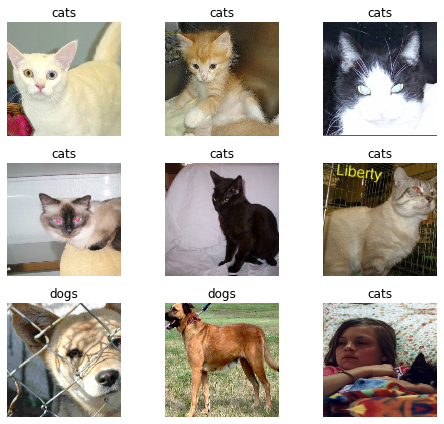

In [14]:
data.show_batch(rows=3, figsize=(7,6))

# Resnet 34
* Reuse resnet34 architecture

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Learning
* Error rate 0.025

In [17]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.252344,0.079041,0.024000,00:34
1,0.175632,0.060598,0.021000,00:33
2,0.135791,0.056008,0.024000,00:33
3,0.086850,0.055807,0.025000,00:34


In [0]:
learn.save('stage-1')

## Accuracy

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

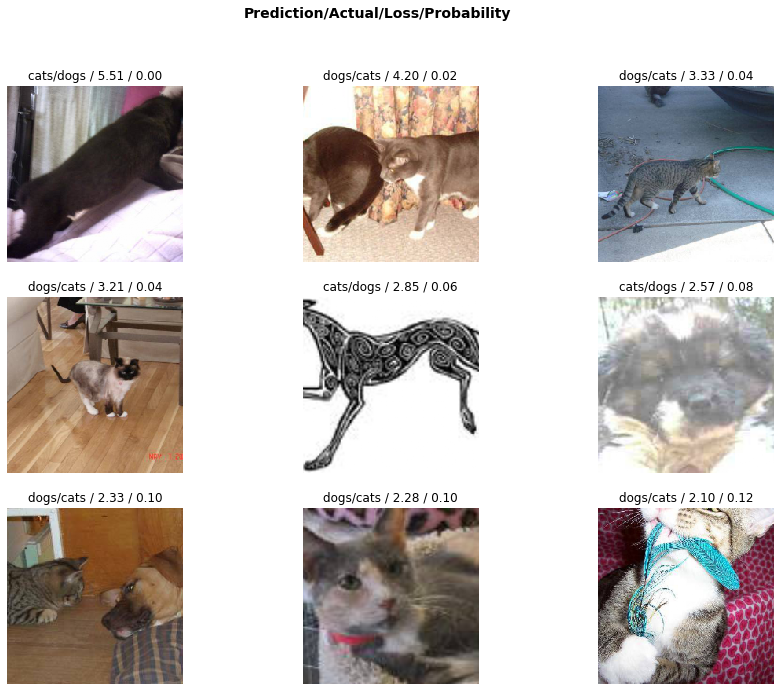

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

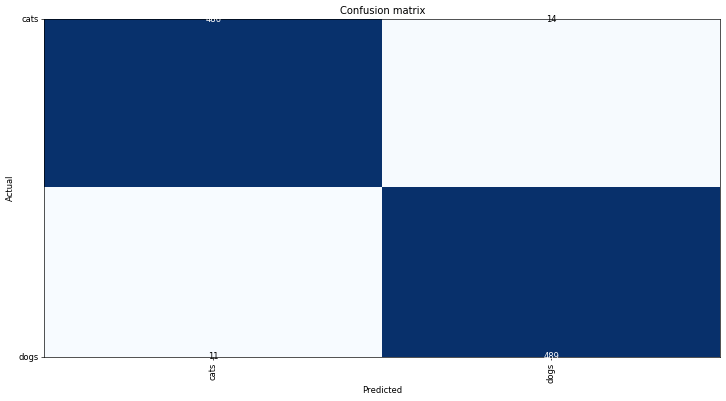

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val=2)

[('cats', 'dogs', 14), ('dogs', 'cats', 11)]

## Unfreezing & Fine Tuning
* Fine tuning may not perform well without revisiting the learning rate
* Our error rate increased from 0.025 to 0.034 (40%)

In [0]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.160112,0.102026,0.034000,00:35


In [0]:
learn.load('stage-1');

## Learning Rate
* Look for a steep (and continued) descent
* Pick range near top and bottom
* Plot doesn't show our learning rates (something to investigate)

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


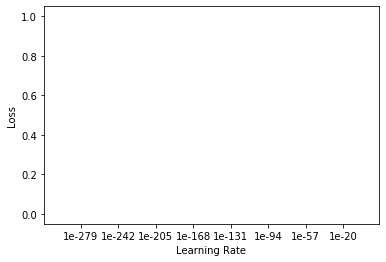

In [30]:
learn.recorder.plot()

In [31]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.050005,0.052103,0.027000,00:36
1,0.049643,0.052515,0.024000,00:35


# Resnet 50


In [0]:
data = ImageDataBunch.from_folder(base_dir, 
                                  train='training', valid='validation', test='test',  
                                  ds_tfms=get_transforms(), 
                                  size=299, bs=batch // 2).normalize(imagenet_stats)

In [34]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


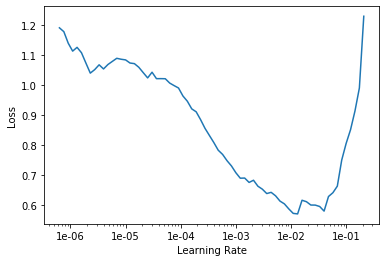

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.201504,0.100820,0.023000,01:22
1,0.215289,0.048663,0.012000,01:18
2,0.121529,0.046711,0.011000,01:17
3,0.081248,0.092369,0.018000,01:17
4,0.104526,0.069283,0.016000,01:17
5,0.072868,0.056814,0.016000,01:18
6,0.074053,0.061157,0.013000,01:18
7,0.056240,0.057036,0.012000,01:18


In [0]:
learn.save('stage-1-50')

In [38]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.162118,0.081293,0.022000,01:44
1,0.101705,0.076750,0.028000,01:40
2,0.077500,0.049184,0.013000,01:40


In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [41]:
interp.most_confused(min_val=2)

[('cats', 'dogs', 6), ('dogs', 'cats', 6)]

# Takeaways
* Even on this small net, use a GPU
* The data is small, you'll be fighting overfitting
* FastAI saves coding and delivers solid results
